# 06. Direct Preference Optimization (DPO)
## Synthetic Instruction Tuner - Week 3 Day 4-5

This notebook performs DPO training on the SFT model:
1. Load SFT-trained model
2. Load preference data (chosen/rejected pairs)
3. Configure DPO training
4. Train with TRL's DPOTrainer
5. Evaluate and save the final model

**DPO settings** (Colab Pro A100 optimized):
- Beta: 0.1 (KL penalty coefficient)
- Epochs: 1
- Learning rate: 5e-5
- Batch size: 8 (A100 40GB VRAM utilization, 4x increase from T4)
- Gradient accumulation: 2

**Expected runtime**:
- T4: 4-6 hours
- A100: 1-2 hours (3-4x faster)

**A100 optimization benefits**:
- DPO loads both policy and reference models simultaneously (highly memory-intensive)
- A100's 40GB VRAM enables 4x larger batches (2→8)
- Expected memory usage: ~30-35GB / 40GB
- Significantly faster training with larger batches

**Note**: DPO directly optimizes for human preferences without needing a separate reward model

## 1. Setup

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Project path
PROJECT_ROOT = "/content/drive/MyDrive/synthetic-instruction-tuner"

Mounted at /content/drive


In [2]:
# Load configuration
import json

with open(f"{PROJECT_ROOT}/config.json", 'r') as f:
    config = json.load(f)

print("Configuration loaded!")

Configuration loaded!


In [3]:
# Install libraries with latest compatible versions (avoid dependency conflicts)
!pip install -q --upgrade transformers>=4.41.0 peft>=0.7.0 trl>=0.7.4 datasets>=2.16.0 accelerate>=0.25.0 bitsandbytes>=0.41.3

print("✅ Libraries installed successfully!")

✅ Libraries installed successfully!


In [4]:
import torch
import json
import os
import time
from datetime import datetime
from datasets import Dataset
import gc

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

PyTorch version: 2.9.0+cu126
CUDA available: True
GPU: NVIDIA A100-SXM4-80GB
GPU Memory: 85.17 GB


In [5]:
# Efficiency Metrics Tracker for DPO
class EfficiencyTracker:
    """Track efficiency metrics for adaptation method comparison."""

    def __init__(self, method_name: str):
        self.method_name = method_name
        self.metrics = {
            "method": method_name,
            "memory_allocated_gb": [],
            "memory_reserved_gb": [],
            "training_time_seconds": 0,
            "trainable_params": 0,
            "total_params": 0,
            "trainable_ratio": 0,
            "inference_tokens_per_sec": 0,
        }
        self.start_time = None

    def log_memory(self):
        if torch.cuda.is_available():
            allocated = torch.cuda.memory_allocated() / 1e9
            reserved = torch.cuda.memory_reserved() / 1e9
            self.metrics["memory_allocated_gb"].append(allocated)
            self.metrics["memory_reserved_gb"].append(reserved)
            return {"allocated": allocated, "reserved": reserved}
        return None

    def start_training(self):
        self.start_time = time.time()
        self.log_memory()

    def end_training(self):
        if self.start_time:
            self.metrics["training_time_seconds"] = time.time() - self.start_time
        self.log_memory()

    def log_params(self, model):
        trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
        total = sum(p.numel() for p in model.parameters())
        self.metrics["trainable_params"] = trainable
        self.metrics["total_params"] = total
        self.metrics["trainable_ratio"] = trainable / total if total > 0 else 0

    def log_inference_speed(self, tokens_generated: int, time_taken: float):
        self.metrics["inference_tokens_per_sec"] = tokens_generated / time_taken if time_taken > 0 else 0

    def get_summary(self):
        return {
            "method": self.method_name,
            "trainable_params": self.metrics["trainable_params"],
            "total_params": self.metrics["total_params"],
            "trainable_ratio_percent": self.metrics["trainable_ratio"] * 100,
            "peak_memory_gb": max(self.metrics["memory_allocated_gb"]) if self.metrics["memory_allocated_gb"] else 0,
            "training_time_hours": self.metrics["training_time_seconds"] / 3600,
            "inference_tokens_per_sec": self.metrics["inference_tokens_per_sec"],
        }

    def save(self, path: str):
        with open(path, 'w') as f:
            json.dump(self.get_summary(), f, indent=2)
        print(f"Metrics saved to {path}")

# Initialize tracker for DPO
tracker = EfficiencyTracker("dpo")
print("Efficiency tracker initialized for DPO!")

Efficiency tracker initialized for DPO!


## 2. Load Preference Data

In [6]:
# Load DPO training data
TRAIN_PATH = f"{config['paths']['data_preference']}/dpo_train.json"
VAL_PATH = f"{config['paths']['data_preference']}/dpo_val.json"

with open(TRAIN_PATH, 'r', encoding='utf-8') as f:
    train_data = json.load(f)

with open(VAL_PATH, 'r', encoding='utf-8') as f:
    val_data = json.load(f)

print(f"Training pairs: {len(train_data)}")
print(f"Validation pairs: {len(val_data)}")

Training pairs: 540
Validation pairs: 60


In [7]:
# Preview data format
print("Sample preference pair:")
print(json.dumps(train_data[0], indent=2, ensure_ascii=False)[:500])

Sample preference pair:
{
  "prompt": "## Step 1:  To find the greatest common divisor (GCD) of two numbers, we need to list the prime factors of each number and identify the common factors.\n## Step 2:  Start with 48 and 90.\n## Step 3:  48 = 2 * 2 * 2 * 2 * 3\n## Step 4:  90 = 2 * 3 * 3 * 5\n## Step 5:  The common factors between 48 and 90 are 2 and 3.\n## Step 6:  The GCD is found by multiplying these common factors together: 2 * 3 = 6.\n## Step 7:  Therefore, the GCD of 48 and 90 is 6.\n\nThe final answer is: $\\bo


In [8]:
# Convert to HuggingFace Dataset
train_dataset = Dataset.from_list(train_data)
val_dataset = Dataset.from_list(val_data)

print(f"Train dataset: {train_dataset}")
print(f"Val dataset: {val_dataset}")

Train dataset: Dataset({
    features: ['prompt', 'chosen', 'rejected'],
    num_rows: 540
})
Val dataset: Dataset({
    features: ['prompt', 'chosen', 'rejected'],
    num_rows: 60
})


## 3. Load SFT Model

In [9]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from peft import PeftModel

# Load base model and SFT adapters
BASE_MODEL_ID = config['models']['sft_base']
SFT_MODEL_PATH = f"{config['paths']['models_sft']}/final"

print(f"Loading base model: {BASE_MODEL_ID}")
print(f"Loading SFT adapters from: {SFT_MODEL_PATH}")

Loading base model: meta-llama/Llama-3.2-3B
Loading SFT adapters from: /content/drive/MyDrive/synthetic-instruction-tuner/models/sft/final


In [10]:
# 4-bit quantization
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
)

In [11]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(SFT_MODEL_PATH)

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.pad_token_id = tokenizer.eos_token_id

tokenizer.padding_side = "left"  # Important for DPO

print(f"Tokenizer loaded. Vocab size: {tokenizer.vocab_size}")

Tokenizer loaded. Vocab size: 128000


In [12]:
# Load base model
base_model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL_ID,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True,
)

print(f"Base model loaded!")

config.json:   0%|          | 0.00/844 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/20.9k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.46G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

Base model loaded!


In [13]:
# Load SFT model (with LoRA adapters)
model = PeftModel.from_pretrained(
    base_model,
    SFT_MODEL_PATH,
    is_trainable=True,  # Make adapters trainable for DPO
)

# Prepare for training
model.config.use_cache = False

# Log parameters and memory
tracker.log_params(model)
mem = tracker.log_memory()

print(f"SFT model loaded!")
print(f"Trainable parameters: {tracker.metrics['trainable_params']:,} ({tracker.metrics['trainable_ratio']*100:.2f}%)")
print(f"GPU Memory: {mem['allocated']:.2f} GB allocated")

SFT model loaded!
Trainable parameters: 12,156,928 (0.67%)
GPU Memory: 2.29 GB allocated


In [14]:
# Load reference model (for KL divergence)
# Use the same SFT model as reference (frozen)
ref_model = PeftModel.from_pretrained(
    AutoModelForCausalLM.from_pretrained(
        BASE_MODEL_ID,
        quantization_config=bnb_config,
        device_map="auto",
        trust_remote_code=True,
    ),
    SFT_MODEL_PATH,
    is_trainable=False,  # Frozen reference model
)

print(f"Reference model loaded!")
print(f"Total GPU Memory: {torch.cuda.memory_allocated() / 1e9:.2f} GB")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Reference model loaded!
Total GPU Memory: 4.58 GB


## 4. Configure DPO Training

## A100 GPU Optimization Settings for DPO

This notebook is optimized for **Google Colab Pro with A100 GPU (40GB VRAM)**.

### DPO-specific memory considerations:

**Dual model loading**: DPO requires loading both:
- Policy model (trainable) - the model being optimized
- Reference model (frozen) - for KL divergence computation

This doubles memory requirements compared to SFT training.

**Batch size: 8** (increased from T4's 2, 4x larger)
- Even with dual models, A100's 40GB VRAM handles batch size 8
- Memory usage: ~30-35GB / 40GB (safe operating range)
- T4 with 15GB can only handle batch size 2

**Gradient accumulation: 2** (unified value from config)
- Effective batch size: 8 × 2 = 16
- Consistent with SFT training approach

**Training speedup: 3-4x faster than T4**
- Larger batches significantly speed up DPO training
- Expected training time: 1-2 hours (vs T4's 4-6 hours)

**Memory safety**: If OOM errors occur, reduce batch size to 4 or 6

In [15]:
from transformers import TrainingArguments
from trl import DPOTrainer

# Output directory
OUTPUT_DIR = f"{config['paths']['models_dpo']}/dpo-checkpoint"
os.makedirs(OUTPUT_DIR, exist_ok=True)

print(f"Output directory: {OUTPUT_DIR}")

Output directory: /content/drive/MyDrive/synthetic-instruction-tuner/models/dpo/dpo-checkpoint


In [22]:
from trl import DPOConfig

# DPO training configuration
training_args = DPOConfig(
    output_dir=OUTPUT_DIR,

    # DPO-specific parameter
    beta=config['training']['dpo_beta'],  # KL penalty coefficient

    # Training hyperparameters
    num_train_epochs=config['training']['dpo_epochs'],
    per_device_train_batch_size=config['training']['dpo_batch_size'],
    per_device_eval_batch_size=config['training']['dpo_batch_size'],
    gradient_accumulation_steps=config['training']['gradient_accumulation_steps'],

    # Optimizer
    learning_rate=config['training']['dpo_learning_rate'],
    weight_decay=0.01,
    optim="paged_adamw_32bit",

    # Learning rate schedule
    lr_scheduler_type="cosine",
    warmup_steps=50,

    # Logging
    logging_dir=f"{OUTPUT_DIR}/logs",
    logging_steps=10,
    logging_first_step=True,

    # Evaluation
    eval_strategy="steps",
    eval_steps=100,

    # Checkpointing
    save_strategy="steps",
    save_steps=100,
    save_total_limit=3,

    # Performance
    fp16=True,
    gradient_checkpointing=True,

    # Misc
    report_to="none",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    remove_unused_columns=False,

    # DPO-specific settings
    max_prompt_length=512,
    max_length=1024,
)

print("DPO training configuration:")
print(f"  Beta (KL penalty): {training_args.beta}")
print(f"  Epochs: {training_args.num_train_epochs}")
print(f"  Batch size: {training_args.per_device_train_batch_size}")
print(f"  Gradient accumulation: {training_args.gradient_accumulation_steps}")
print(f"  Effective batch size: {training_args.per_device_train_batch_size * training_args.gradient_accumulation_steps}")
print(f"  Learning rate: {training_args.learning_rate}")

DPO training configuration:
  Beta (KL penalty): 0.1
  Epochs: 1
  Batch size: 8
  Gradient accumulation: 2
  Effective batch size: 16
  Learning rate: 5e-05


## 5. Initialize DPO Trainer

In [24]:
# DPO Trainer
dpo_trainer = DPOTrainer(
    model=model,
    ref_model=ref_model,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    processing_class=tokenizer,
    args=training_args,
)

print(f"DPO Trainer initialized!")
print(f"  Beta (KL penalty): {training_args.beta}")

Extracting prompt in train dataset:   0%|          | 0/540 [00:00<?, ? examples/s]

Applying chat template to train dataset:   0%|          | 0/540 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/540 [00:00<?, ? examples/s]

Extracting prompt in eval dataset:   0%|          | 0/60 [00:00<?, ? examples/s]

Applying chat template to eval dataset:   0%|          | 0/60 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/60 [00:00<?, ? examples/s]

DPO Trainer initialized!
  Beta (KL penalty): 0.1


## 6. Train Model with DPO

In [25]:
# Start DPO training with timing
print("Starting DPO training...")
print(f"Start time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("=" * 50)

tracker.start_training()
train_result = dpo_trainer.train()
tracker.end_training()

print("\n" + "=" * 50)
print(f"DPO training completed!")
print(f"End time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Training time: {tracker.metrics['training_time_seconds']/3600:.2f} hours")

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 128001}.


Starting DPO training...
Start time: 2025-12-26 18:10:07


Step,Training Loss,Validation Loss



DPO training completed!
End time: 2025-12-26 18:12:20
Training time: 0.04 hours


In [26]:
# Print training metrics
print("\nTraining metrics:")
print(f"  Final train loss: {train_result.training_loss:.4f}")
print(f"  Total steps: {train_result.global_step}")


Training metrics:
  Final train loss: 0.6505
  Total steps: 34


## 7. Evaluate Model

In [27]:
# Evaluate on validation set
print("Evaluating DPO model...")
eval_results = dpo_trainer.evaluate()

print("\nEvaluation metrics:")
for key, value in eval_results.items():
    if isinstance(value, (int, float)):
        print(f"  {key}: {value:.4f}")

Evaluating DPO model...



Evaluation metrics:
  eval_loss: 0.5512
  eval_runtime: 6.9103
  eval_samples_per_second: 8.6830
  eval_steps_per_second: 1.1580
  eval_rewards/chosen: -0.3547
  eval_rewards/rejected: -0.7609
  eval_rewards/accuracies: 0.7031
  eval_rewards/margins: 0.4061
  eval_logps/chosen: -117.8401
  eval_logps/rejected: -126.4317
  eval_logits/chosen: 0.3878
  eval_logits/rejected: 0.5329
  epoch: 1.0000


## 8. Test Generation

In [28]:
def generate_response(instruction: str, max_new_tokens: int = 256):
    """Generate a response for the given instruction with timing."""
    prompt = f"<|begin_of_text|><|start_header_id|>user<|end_header_id|>\n\n{instruction}<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n"

    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    with torch.no_grad():
        start_time = time.time()
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            temperature=0.7,
            do_sample=True,
            top_p=0.9,
            pad_token_id=tokenizer.eos_token_id,
        )
        gen_time = time.time() - start_time

    tokens_generated = outputs.shape[1] - inputs['input_ids'].shape[1]
    generated = tokenizer.decode(outputs[0], skip_special_tokens=False)

    # Extract response
    if "<|start_header_id|>assistant<|end_header_id|>" in generated:
        response = generated.split("<|start_header_id|>assistant<|end_header_id|>")[-1]
        response = response.split("<|eot_id|>")[0].strip()
        return response, tokens_generated, gen_time

    return generated, tokens_generated, gen_time

print("Generation function defined!")

Generation function defined!


In [29]:
# Test generation and measure inference speed
test_instructions = [
    "Explain the concept of machine learning in simple terms.",
    "Write a Python function to calculate the factorial of a number.",
    "What are the main differences between supervised and unsupervised learning?",
    "Describe the process of photosynthesis.",
    "How can I improve my coding skills?",
]

print("Testing DPO fine-tuned model generation:")
print("=" * 50)

total_tokens = 0
total_time = 0

for i, instruction in enumerate(test_instructions):
    print(f"\n[Test {i+1}]")
    print(f"Instruction: {instruction}")
    print(f"\nResponse:")
    response, tokens, gen_time = generate_response(instruction, max_new_tokens=200)
    print(response)
    print(f"\nTokens: {tokens}, Time: {gen_time:.2f}s, Speed: {tokens/gen_time:.1f} tok/s")
    print("-" * 50)

    total_tokens += tokens
    total_time += gen_time

# Log inference speed
tracker.log_inference_speed(total_tokens, total_time)
print(f"\nAverage inference speed: {tracker.metrics['inference_tokens_per_sec']:.1f} tokens/sec")

Testing DPO fine-tuned model generation:

[Test 1]
Instruction: Explain the concept of machine learning in simple terms.

Response:
Machine learning is a field of computer science that enables computers to learn from and make predictions based on data without being explicitly programmed.

It involves training algorithms on large datasets to identify patterns and relationships that can be used to make predictions or decisions in specific contexts.

Here's a simplified explanation of the concept:

Imagine you have a dataset of historical stock prices and you want to predict whether the price of a stock will go up or down in the next day. A machine learning algorithm would analyze the historical data to identify patterns such as price movements, volume, and other relevant features, and use that information to make predictions about future stock prices.

This process involves training the algorithm using historical data, adjusting its parameters or weights to optimize its performance, and 

## 9. Compare SFT vs DPO Outputs

In [30]:
# Load SFT model for comparison
print("Loading SFT model for comparison...")

sft_model = PeftModel.from_pretrained(
    AutoModelForCausalLM.from_pretrained(
        BASE_MODEL_ID,
        quantization_config=bnb_config,
        device_map="auto",
        trust_remote_code=True,
    ),
    SFT_MODEL_PATH,
)

print("SFT model loaded for comparison!")

Loading SFT model for comparison...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

SFT model loaded for comparison!


In [31]:
def generate_comparison(instruction: str, max_new_tokens: int = 200):
    """Generate responses from both SFT and DPO models."""
    prompt = f"<|begin_of_text|><|start_header_id|>user<|end_header_id|>\n\n{instruction}<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n"
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    # Generate with SFT model
    with torch.no_grad():
        sft_outputs = sft_model.generate(
            **inputs, max_new_tokens=max_new_tokens, temperature=0.7,
            do_sample=True, top_p=0.9, pad_token_id=tokenizer.eos_token_id,
        )
    sft_text = tokenizer.decode(sft_outputs[0], skip_special_tokens=False)
    sft_response = sft_text.split("<|start_header_id|>assistant<|end_header_id|>")[-1].split("<|eot_id|>")[0].strip()

    # Generate with DPO model
    with torch.no_grad():
        dpo_outputs = model.generate(
            **inputs, max_new_tokens=max_new_tokens, temperature=0.7,
            do_sample=True, top_p=0.9, pad_token_id=tokenizer.eos_token_id,
        )
    dpo_text = tokenizer.decode(dpo_outputs[0], skip_special_tokens=False)
    dpo_response = dpo_text.split("<|start_header_id|>assistant<|end_header_id|>")[-1].split("<|eot_id|>")[0].strip()

    return sft_response, dpo_response

# Compare on test instructions
print("\nComparing SFT vs DPO outputs:")
print("=" * 50)

for i, instruction in enumerate(test_instructions[:3]):
    print(f"\n[Comparison {i+1}]")
    print(f"Instruction: {instruction}\n")

    sft_resp, dpo_resp = generate_comparison(instruction)

    print(f"SFT Response:")
    print(sft_resp[:300] + "..." if len(sft_resp) > 300 else sft_resp)
    print(f"\nDPO Response:")
    print(dpo_resp[:300] + "..." if len(dpo_resp) > 300 else dpo_resp)
    print("\n" + "-" * 50)


Comparing SFT vs DPO outputs:

[Comparison 1]
Instruction: Explain the concept of machine learning in simple terms.

SFT Response:
Machine learning is a field of artificial intelligence that enables computers to learn from data without being explicitly programmed. It involves developing algorithms that can adapt to new data and make predictions or decisions based on patterns or trends in the data.

To understand the concept of ...

DPO Response:
## Step 1: Understand the definition of machine learning
Machine learning is a field of artificial intelligence that allows computers to learn from data, identify patterns, and make predictions or decisions without being explicitly programmed.

## Step 2: Define the concept of machine learning model...

--------------------------------------------------

[Comparison 2]
Instruction: Write a Python function to calculate the factorial of a number.

SFT Response:
## Step 1: Understand the problem
The problem is asking us to calculate the factorial

## 10. Save Final DPO Model

In [33]:
# Save the final DPO model
FINAL_MODEL_DIR = f"{config['paths']['models_dpo']}/final"

print(f"Saving final DPO model to: {FINAL_MODEL_DIR}")

dpo_trainer.save_model(FINAL_MODEL_DIR)
tokenizer.save_pretrained(FINAL_MODEL_DIR)

print("Model saved!")

Saving final DPO model to: /content/drive/MyDrive/synthetic-instruction-tuner/models/dpo/final
Model saved!


In [34]:
# Save training configuration
training_config = {
    "base_model": BASE_MODEL_ID,
    "sft_model": SFT_MODEL_PATH,
    "training_data_size": len(train_data),
    "validation_data_size": len(val_data),
    "dpo_config": {
        "beta": config['training']['dpo_beta'],
        "epochs": config['training']['dpo_epochs'],
        "learning_rate": config['training']['dpo_learning_rate'],
        "batch_size": config['training']['dpo_batch_size'],
    },
    "results": {
        "train_loss": train_result.training_loss,
        "eval_loss": eval_results.get("eval_loss", None),
        "total_steps": train_result.global_step,
    },
    "timestamp": datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
}

config_path = f"{FINAL_MODEL_DIR}/training_config.json"
with open(config_path, 'w') as f:
    json.dump(training_config, f, indent=2)

print(f"Training config saved to: {config_path}")

Training config saved to: /content/drive/MyDrive/synthetic-instruction-tuner/models/dpo/final/training_config.json


## 11. Plot Training Curves

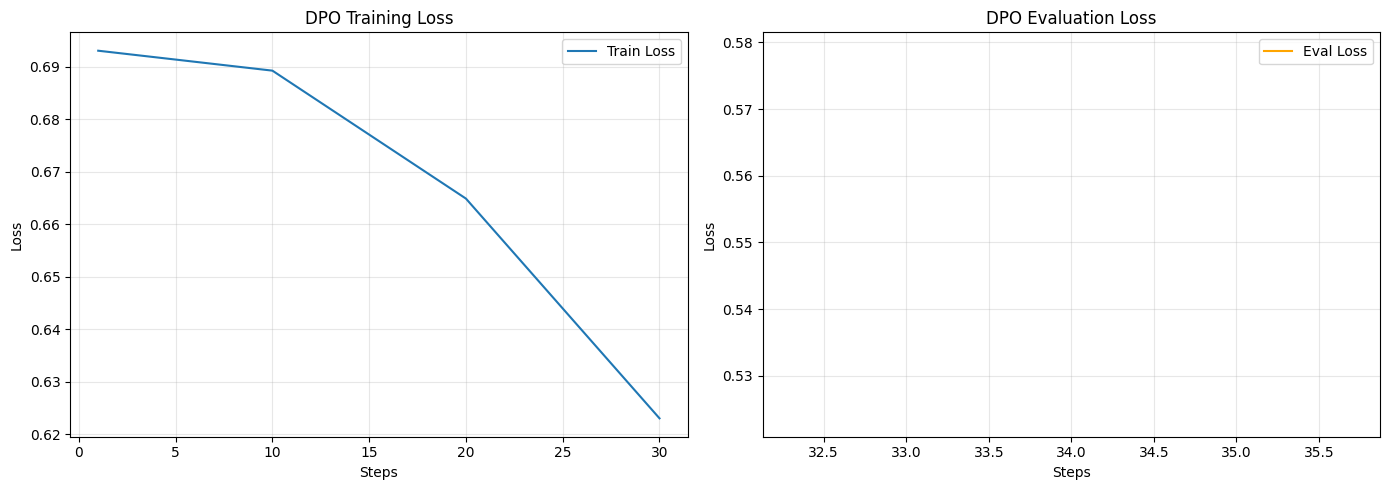

Training curves saved to /content/drive/MyDrive/synthetic-instruction-tuner/evaluation/figures/dpo_training_curves.png


In [35]:
import matplotlib.pyplot as plt

# Load training logs
log_history = dpo_trainer.state.log_history

# Extract losses
train_logs = [log for log in log_history if 'loss' in log]
eval_logs = [log for log in log_history if 'eval_loss' in log]

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training loss
if train_logs:
    steps = [log['step'] for log in train_logs]
    losses = [log['loss'] for log in train_logs]
    axes[0].plot(steps, losses, label='Train Loss')
    axes[0].set_xlabel('Steps')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('DPO Training Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

# Evaluation loss
if eval_logs:
    steps = [log['step'] for log in eval_logs]
    losses = [log['eval_loss'] for log in eval_logs]
    axes[1].plot(steps, losses, label='Eval Loss', color='orange')
    axes[1].set_xlabel('Steps')
    axes[1].set_ylabel('Loss')
    axes[1].set_title('DPO Evaluation Loss')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{config['paths']['evaluation_figures']}/dpo_training_curves.png", dpi=150)
plt.show()

print(f"Training curves saved to {config['paths']['evaluation_figures']}/dpo_training_curves.png")

In [36]:
# Save DPO efficiency metrics for comparison
METRICS_DIR = f"{PROJECT_ROOT}/evaluation/metrics"
os.makedirs(METRICS_DIR, exist_ok=True)

# Get summary
summary = tracker.get_summary()

# Add training results
summary["train_loss"] = train_result.training_loss
summary["eval_loss"] = eval_results.get("eval_loss", None)

# Save
tracker.save(f"{METRICS_DIR}/dpo_metrics.json")

print("\n=== DPO Efficiency Metrics Summary ===")
for key, value in summary.items():
    if isinstance(value, float):
        print(f"  {key}: {value:.4f}")
    else:
        print(f"  {key}: {value}")

Metrics saved to /content/drive/MyDrive/synthetic-instruction-tuner/evaluation/metrics/dpo_metrics.json

=== DPO Efficiency Metrics Summary ===
  method: dpo
  trainable_params: 12156928
  total_params: 1815620608
  trainable_ratio_percent: 0.6696
  peak_memory_gb: 4.6982
  training_time_hours: 0.0368
  inference_tokens_per_sec: 8.7328
  train_loss: 0.6505
  eval_loss: 0.5512


## 12. Cleanup

In [37]:
# Free GPU memory
del model
del ref_model
del sft_model
del dpo_trainer
gc.collect()
torch.cuda.empty_cache()

print("Memory cleared!")

Memory cleared!


## ✓ DPO Training Complete!

### Summary:
- DPO-aligned model saved to `models/dpo/final/`
- Model trained to prefer high-quality responses based on reward model scores
- Training configuration and metrics saved

### Model Loading:
To load the final DPO model:
```python
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import PeftModel

base_model = AutoModelForCausalLM.from_pretrained(BASE_MODEL_ID)
model = PeftModel.from_pretrained(base_model, FINAL_MODEL_DIR)
tokenizer = AutoTokenizer.from_pretrained(FINAL_MODEL_DIR)
```

### Next Steps:
1. Week 4: Proceed to evaluation notebooks
2. `07_benchmark_evaluation.ipynb` - Evaluate on standard benchmarks (IFEval, MT-Bench)
3. `08_agent_evaluation.ipynb` - Test agent capabilities